In [1]:
!pwd

/kaggle/working


In [2]:
import os
import zipfile

def zip_folder(folder_path, output_zip):
    """
    Zip the contents of an entire folder (with that folder included
    in the archive). Empty directories are included in the archive as well.
    """
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        lenDirPath = len(folder_path)
        for root, _, files in os.walk(folder_path):
            # Include all subdirectories, including empty ones.
            for dirName in os.listdir(root):
                dirPath = os.path.join(root, dirName)
                if os.path.isdir(dirPath):
                    zipf.write(dirPath, os.path.relpath(dirPath, folder_path))
            # Add files
            for file in files:
                filePath = os.path.join(root, file)
                zipf.write(filePath, os.path.relpath(filePath, folder_path))

In [3]:
zip_folder("/kaggle/input/isig-wheels/iisignature-0.24", "./isig.zip")

!pip install "./isig.zip"

Processing ./isig.zip
  Preparing metadata (setup.py) ... - \ done
  Created wheel for iisignature: filename=iisignature-0.24-cp310-cp310-linux_x86_64.whl size=1401821 sha256=fa707365d58b171e8f0982688bcbbfd49d913868e9f6e346b6fdfe36023f91dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-e5pgom3u/wheels/1e/cc/c1/df8da0c28148d0b5dd2ba81acb40a50cda02da4b95bba89080
Successfully built iisignature


In [4]:
from basic_preprocessing_utility_script import process_as_h5, signature, get_eeg_sp_data, zip_folder

iisignature is already installed.


In [5]:
import sys
sys.path.append('/kaggle/usr/lib')

import numpy as np
import pandas as pd
import os
import time
import h5py
from tqdm import tqdm

import iisignature as isig

import matplotlib.pyplot as plt



In [6]:
# filename = '/kaggle/input/hms-harmful-brain-activity-classification/train.csv'
# process_as_h5(filename, num_examples = 1000)

In [7]:
hdf5_file = '/kaggle/input/generate-h5-data/hdf5/processed_dataset_1000.h5'
num_examples = 1000



with h5py.File(hdf5_file, 'r') as file:
    # List all groups
    
    print("Keys: %s" % file.keys())
    
    file_keys = list(file.keys())

    a_group_key = list(file.keys())[0]
    
    eeg_data = np.array(file[f"eeg"])
    sp_data = np.array(file[f"sp"])
    targets = np.array(file[f"targets"])
    num_votes = np.array(file[f"num_votes"])
    num_votes = num_votes.reshape((len(num_votes), -1))
    

Keys: <KeysViewHDF5 ['eeg', 'num_votes', 'sp', 'targets']>


## We try just using the EEG data

In [8]:
print(eeg_data.shape)
print(targets.shape)
print(sp_data.shape)

(1000, 2000, 18)
(1000, 6)
(1000, 4, 300, 100)


## We try applying the signature across each signal

### We apply the signature across the different streams (there are 4 of length 4, and then one 'other' of length 2)

In [9]:
eeg_streams = [eeg_data[:,:,:4],  eeg_data[:,:,4:8], eeg_data[:,:,8:12], eeg_data[:,:,12:16], eeg_data[:,:,16:]]
eeg_stream_sig = [signature(stream, level=4) for stream in eeg_streams]


In [10]:
for stream in eeg_stream_sig:
    print(stream.shape)

(1000, 340)
(1000, 340)
(1000, 340)
(1000, 340)
(1000, 30)


In [11]:
eeg_sig = np.concatenate(eeg_stream_sig, axis=-1)

print(eeg_sig.shape)

(1000, 1390)


Create historgram of values in eeg_sig to see in what range values in the signautre are in

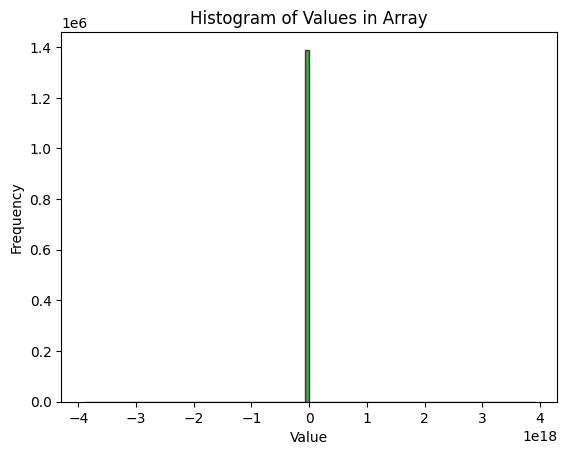

In [12]:
# Creating the histogram
import matplotlib.pyplot as plt

plt.hist(eeg_sig.reshape(-1), bins=100, alpha=0.7, color='green', edgecolor='black')

plt.title('Histogram of Values in Array')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

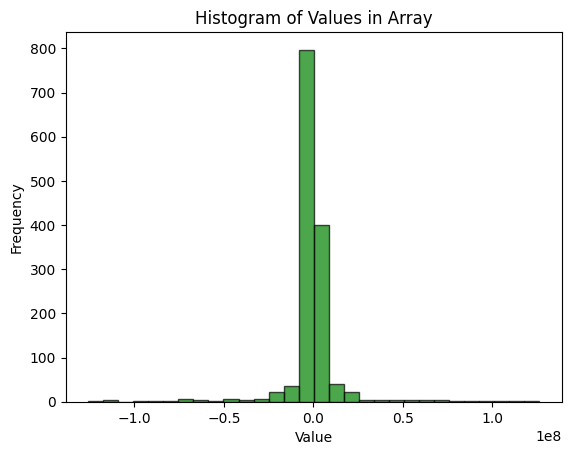

In [13]:
# Creating the histogram
plt.hist(eeg_sig[0], bins=30, alpha=0.7, color='green', edgecolor='black')

plt.title('Histogram of Values in Array')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

### We clip the output of the signature to be between -0.5 and 0.5

In [14]:
eeg_sig_clip = np.clip(eeg_sig, a_min=-0.5, a_max=0.5)

### Write the above preprocessing steps as a single function

In [15]:
def preprocess(pre_eeg):
    pre_eeg_streams = [pre_eeg[:,:,:4],  pre_eeg[:,:,4:8], pre_eeg[:,:,8:12],
                       pre_eeg[:,:,12:16], pre_eeg[:,:,16:]]
    
    pre_eeg_stream_sig = [signature(stream, level=4) for stream in pre_eeg_streams]
    pre_eeg_sig = np.concatenate(pre_eeg_stream_sig, axis=-1)
    pre_eeg_sig_clip = np.clip(pre_eeg_sig, a_min=-0.5, a_max=0.5)
    return pre_eeg_sig_clip
    
    

In [16]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# Mock data
features = eeg_sig_clip
targets = targets

# Convert to PyTorch tensors
features_tensor = torch.tensor(features, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32)

# Create a TensorDataset
dataset = TensorDataset(features_tensor, targets_tensor)

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



import torch.nn as nn
import torch.nn.functional as F

class DeeperNN(nn.Module):
    def __init__(self):
        super(DeeperNN, self).__init__()
        self.fc1 = nn.Linear(1390, 1024)  # Increase the number of neurons
        self.bn1 = nn.BatchNorm1d(1024)   # Batch normalization
        self.dropout1 = nn.Dropout(0.5)   # Dropout
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.5)
        
        self.fc5 = nn.Linear(128, 6)     # Final layer remains the same

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)
        
        x = self.fc5(x)
        return F.log_softmax(x, dim=1) # Ensure output sums to 1

# Initialize the model
model = DeeperNN()





In [17]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Assume nn, model, train_loader, and test_loader are already defined

# Loss function and optimizer
criterion = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.Adam(model.parameters(), lr=0.01)

losses = []  # List to store the average loss per epoch
test_losses = []  # List to store the average test loss per epoch

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)

    # Evaluate on test set
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_loss = criterion(outputs, labels)
            total_test_loss += test_loss.item()
    
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    print(f"Epoch {epoch+1}, Training Loss: {avg_loss}, Test Loss: {avg_test_loss}")

Epoch 1, Training Loss: 0.8577134517522959, Test Loss: 1.603453904390335
Epoch 2, Training Loss: 0.6461869340676528, Test Loss: 0.6705722212791443
Epoch 3, Training Loss: 0.5539272129535675, Test Loss: 0.5892156064510345
Epoch 4, Training Loss: 0.4821328016427847, Test Loss: 0.5287942662835121
Epoch 5, Training Loss: 0.40190914502510655, Test Loss: 0.5406680926680565
Epoch 6, Training Loss: 0.33846426812502056, Test Loss: 0.5326718240976334
Epoch 7, Training Loss: 0.30986438118494475, Test Loss: 0.525393083691597
Epoch 8, Training Loss: 0.280386739052259, Test Loss: 0.4922487735748291
Epoch 9, Training Loss: 0.26603485758487994, Test Loss: 0.4906625971198082
Epoch 10, Training Loss: 0.2454857975244522, Test Loss: 0.5481070280075073
Epoch 11, Training Loss: 0.2576063401423968, Test Loss: 0.48658687621355057
Epoch 12, Training Loss: 0.24102521515809572, Test Loss: 0.48384372889995575
Epoch 13, Training Loss: 0.21870152079142058, Test Loss: 0.553230345249176
Epoch 14, Training Loss: 0.209

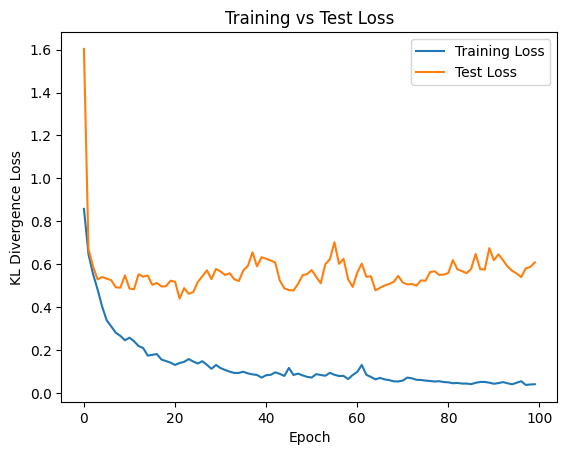

In [18]:


# Plotting
plt.plot(losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training vs Test Loss')
plt.xlabel('Epoch')
plt.ylabel('KL Divergence Loss')
plt.legend()
plt.show()


## Try Submitting

In [19]:
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape:',test.shape)


EEG_SUB_PATH_TEMPL = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'
SP_SUB_PATH_TEMPL = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'

test.head()

test.iloc[0]

Test shape: (1, 3)


spectrogram_id        853520
eeg_id            3911565283
patient_id              6885
Name: 0, dtype: int64

In [20]:
# # Read all spectrograms
# PATH = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms'
# files = os.listdir(PATH)
# print(f'There are {len(files)} test spectrogram parquets')
# test_specs = {}
# for i,f in enumerate(files):
#     tmp = pd.read_parquet(f'{PATH}/{f}')
#     name = int(f.split('.')[0])
#     print(tmp)
#     test_specs[name] = tmp.iloc[:,1:].values

In [21]:
def get_sub_eeg_sp_data(train_row):
    """Gets EEG and Spectogram data from a specific row in the dataset"""
    
    eeg_id = train_row.eeg_id
    sp_id = train_row.spectrogram_id
    
    eeg_parquet = pd.read_parquet(f'{EEG_SUB_PATH_TEMPL}{eeg_id}.parquet')
    sp = pd.read_parquet(f'{SP_SUB_PATH_TEMPL}{sp_id}.parquet')
    
    rows = len(eeg_parquet)
    eeg_offset = (rows-10_000)//2
    
    
    # get middle 50 seconds of eeg data
    #eeg_offset = int(train_row.eeg_label_offset_seconds + 20) #only 10 central seconds from 50 secs were labeled, which should be seconds 20-30 in the sample
    eeg_data = eeg_parquet.iloc[eeg_offset:eeg_offset + 10_000]
    
    
    # sp_offset = int(train_row.spectrogram_label_offset_seconds )
    
    # get spectrogram data
    # sp = sp_parquet.loc[(sp_parquet.time>=sp_offset)&(sp_parquet.time<sp_offset+SP_WIN)]
    sp = sp.loc[:, sp.columns != 'time']
    sp = {
        "LL": sp.filter(regex='^LL', axis=1),
        "RL": sp.filter(regex='^RL', axis=1),
        "RP": sp.filter(regex='^RP', axis=1),
        "LP": sp.filter(regex='^LP', axis=1)}
    
    # calculate eeg data
    # print(eeg_data.keys()) # Has keys Index(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz',
                            # 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
    # assert 0 == 1
    
    CHAINS = {
    'LL' : [("Fp1","F7"),("F7","T3"),("T3","T5"),("T5","O1")],
    'RL' : [("Fp2","F8"),("F8","T4"),("T4","T6"),("T6","O2")],
    'LP' : [("Fp1","F3"),("F3","C3"),("C3","P3"),("P3","O1")],
    'RP' : [("Fp2","F4"),("F4","C4"),("C4","P4"),("P4","O2")],
    'other' : [("Fz","Cz"), ("Cz", "Pz"), ("EKG")]
}
    
    eeg = pd.DataFrame({})
    for chain in CHAINS.keys():
        for s_i, signals in enumerate(CHAINS[chain]):
            if len(signals) == 2:
                diff=eeg_data[signals[0]]-eeg_data[signals[1]] # Subtracts relevant fields as in the image above
                diff.ffill(inplace = True) # forward fills in the casse of nan values
                eeg[f"{chain}: {signals[0]} - {signals[1]}"] = diff
            
            elif len(signals) == 1:
                sig=eeg_data[signals[0]]
                sig.ffill(inplace = True) 
                eeg[f"{chain}: {signals[0]}"] = sig
                
                
    
    return eeg, sp

In [22]:
eeg_arr = []
for i in tqdm(range(len(test))):
        exp_row = test.iloc[i]
        eeg_data, sp_dict = get_sub_eeg_sp_data(exp_row)
        eeg_arr.append(eeg_data.to_numpy())

# eeg_sub, sp_sub = get_sub_eeg_sp_data(test.iloc[0])

eeg_arr = np.array(eeg_arr)

eeg_arr

100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


array([[[ 26.11      ,   6.09      ,   2.83      , ..., -12.41      ,
          31.380001  ,  24.289999  ],
        [ 65.39001   , -47.380005  ,  -6.5200005 , ..., -12.78      ,
          35.34      ,  23.3       ],
        [  8.649998  ,  -3.289999  ,   0.52000046, ..., -25.64      ,
          26.83      ,  21.        ],
        ...,
        [-43.39      ,  18.630001  ,  28.78      , ..., -52.12      ,
         -16.39      ,  21.629997  ],
        [-44.690002  ,  23.130001  ,  25.96      , ..., -50.050003  ,
         -14.73      ,  20.920002  ],
        [-37.53      ,  27.5       ,  22.44      , ..., -40.63      ,
          -3.75      ,  23.39      ]]], dtype=float32)

In [23]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})

In [24]:
eeg_arr.shape

(1, 10000, 18)

In [25]:
# eeg_sub = np.expand_dims(eeg_sub, axis=0)

# print(eeg_sub.shape)

In [26]:
prep_eeg_sub = preprocess(eeg_arr)

In [27]:
print(prep_eeg_sub.shape)

(1, 1390)


In [28]:
model.eval()

sub_pred = model(torch.from_numpy(prep_eeg_sub).float()) # this gives the log of the probs

sub_pred = np.exp(sub_pred.detach().numpy())

print("This is the sub pred sum:",sub_pred.sum())
print(sub_pred)

This is the sub pred sum: 0.9999999
[[7.2164971e-01 1.1226309e-03 7.7744685e-02 4.3751343e-04 1.5553705e-01
  4.3508321e-02]]


In [29]:
# CREATE SUBMISSION.CSV
from IPython.display import display

TARGETS = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
sub[TARGETS] = sub_pred
sub.to_csv('submission.csv',index=False)
print('Submission shape',sub.shape)
display( sub.head() )

# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
print('Sub row 0 sums to:',sub.iloc[0,-6:].sum())

Submission shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.72165,0.001123,0.077745,0.000438,0.155537,0.043508


Sub row 0 sums to: 0.9999999107967597
